In [1]:
#!/usr/bin/env python3

import os
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from IPython import display
from readcountclass import DiffGeneTable, make_responders_dict
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

In [3]:
#main_data_dir = sys.argv[1]
main_data_dir = "/Users/nicolasdeneuter/Bestanden/PhD/Projects/GOA/RNAseq/readcounts/ML_pipeline"
resp_dict = make_responders_dict(threshold = 100)
subdirmap = {}
fold_change = 7
padj_threshold = 0.1

# for each subdir in the main directory, find result files (each contrast has a different result file)
for x in os.walk(main_data_dir):
    subdir = x[0]
    if subdir == main_data_dir:
        continue
    data_files = glob(subdir+'/results*')
    # for each contrast's result:
    # make a dataframe containing a single row (ie one volunteer) containing log fold changes for each column/gene
    for data_file in data_files:
        # determine characteristics of file
        volunteer = data_file.split('/')[-2]
        contrast = data_file.split('/')[-1].replace('.txt','').replace('results_','')
        resp = resp_dict[volunteer]
        
        ## skip day 3 vs 7 contrast because it's the difference of the other contrasts
        #if contrast == '3_7':
        #    continue
        
        # read in and format data
        diff_gene_table = pd.read_csv(data_file).set_index('Unnamed: 0')
        
        # filter genes by fold change
        diff_gene_table = diff_gene_table[(diff_gene_table['log2FoldChange'] > fold_change)|\
                                              (diff_gene_table['log2FoldChange'] < -fold_change)]
        
        ## filter genes by adjusted p-value
        #diff_gene_table = diff_gene_table[diff_gene_table['padj'] <= padj_threshold]
        
        gene_folds = diff_gene_table.transpose().loc[['log2FoldChange']]
        gene_folds = gene_folds.rename(index={'log2FoldChange': '{}'.format(volunteer)}, 
                                       columns={name: '{}_{}'.format(name, contrast) for name in gene_folds.columns})
        gene_folds.columns.name = 'volunteer_resp'
        gene_folds = gene_folds[[x for x in gene_folds.columns if 'gene' in x]]
        subdirmap.setdefault(volunteer, []).append(gene_folds)

In [4]:
temp_fold_frames = []
# combine dataframe on same volunteer but different contrasts into one dataframe
# result for each volunteer is a new dataframe with one row and columns containing gene+contrast info
for volunteer, gene_fold_list in subdirmap.items():
    temp_fold = pd.concat(gene_fold_list, axis = 1)
    temp_fold['response'] = resp_dict[volunteer]
    temp_fold_frames.append(temp_fold)
    print('{}: {}'.format(volunteer, temp_fold.shape[1]))

H35: 2641
H34: 3514
H10: 2232
H3: 1645
H8: 1808
H39: 3523
H30: 1606
H31: 2764
H33: 2634
H38: 3114
H19: 985
H26: 2342
H4: 1241
H17: 1563
H23: 1667
H11: 2201
H6: 3148
H14: 679
H7: 1412
H20: 902
H41: 3332
H42: 2531
H24: 1736
H22: 2068
H13: 1513
H36: 3717
H40: 3479
H2: 2190
H28: 1827
H21: 1010
H25: 790
H29: 2043


In [5]:
gene_fold = temp_fold_frames[0]
for i in range(1, len(temp_fold_frames)):
    gene_fold_to_add = temp_fold_frames[i]
    gene_fold = gene_fold.append(gene_fold_to_add)
    print(gene_fold.shape)
    
# replace missing values with 0
total_gene_fold = gene_fold.fillna(0)

(2, 5854)
(3, 7701)
(4, 8950)
(5, 10312)
(6, 12777)
(7, 13834)
(8, 15757)
(9, 17279)
(10, 18952)
(11, 19391)
(12, 20627)
(13, 21203)
(14, 21814)
(15, 22498)
(16, 23426)
(17, 24855)
(18, 25096)
(19, 25719)
(20, 26022)
(21, 27310)
(22, 28176)
(23, 28758)
(24, 29383)
(25, 29747)
(26, 31154)
(27, 32168)
(28, 32682)
(29, 33120)
(30, 33353)
(31, 33537)
(32, 33938)


In [6]:
X = total_gene_fold[[x for x in total_gene_fold.columns if x != 'response']]
y = total_gene_fold['response']
display.display(X)

,gene0_0_3,gene0_0_7,gene0_3_7,gene10001_0_3,gene10001_0_7,gene10001_3_7,gene10006_0_3,gene10006_0_7,gene10006_3_7,gene10007_0_3,...,gene9996_3_7,gene9998_0_3,gene9998_0_7,gene9998_3_7,gene999_0_3,gene999_0_7,gene999_3_7,gene9_0_3,gene9_0_7,gene9_3_7
H35,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,7.033835,0.000000,0.000000,0.000000,0.000000,0.000000
H34,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.160658,0.000000,...,0.000000,7.801490,8.120895,0.000000,0.000000,8.532772,0.000000,0.000000,0.000000,0.000000
H10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
H3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-7.972161,-7.313796,0.000000,0.000000,0.000000,0.000000
H8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
H39,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.132514,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
H30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,7.406559,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
H31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.466966,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.930036,-7.873397,0.000000
H33,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,7.312922,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
H38,0.000000,0.000000,0.000000,0.000000,-9.901626,0.000000,-7.645418,-9.693708,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.874987,0.000000,0.000000,0.000000


In [7]:
nonzerovalues = {column: np.count_nonzero(X[column]) for column in X.columns}

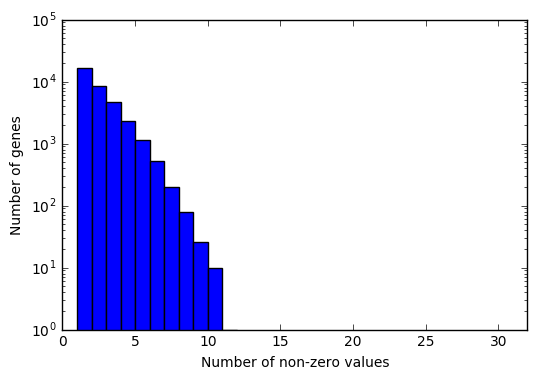

In [8]:
for key, value in nonzerovalues.items():
    if value == 0:
        display.display(key, X[key])
        break

# plot histogram of how many non-zero values the features contain
plt.hist(list(nonzerovalues.values()), bins = range(len(X)))
plt.ylabel('Number of genes')
plt.yscale('log')
plt.xlabel('Number of non-zero values')
plt.xlim(0, len(X))
plt.show()

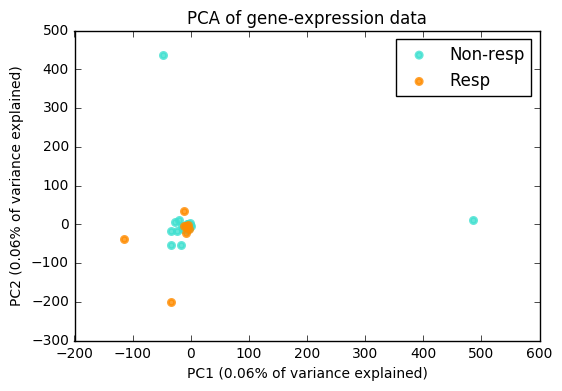

In [9]:
pca = PCA(n_components = 2)
X_r = pd.DataFrame(pca.fit(X).transform(X), index = X.index)

plt.figure()
colors = ['turquoise', 'darkorange']
target_names = ['Non-resp', 'Resp']
label = [float(x.replace('H','')) for x in X_r.index]
for color, target_name in zip(colors, target_names):
    plt.scatter(X_r[y == target_name][0], X_r[y == target_name][1], color=color, alpha=.8, lw=2, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel('PC1 ({0:.2f}% of variance explained)'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({0:.2f}% of variance explained)'.format(pca.explained_variance_ratio_[1]))
plt.title('PCA of gene-expression data')
#for i, txt in enumerate(label):
#    plt.annotate('H'+str(int(txt)), (X_r[0][i],X_r[1][i]))
plt.show()

In [10]:
results = []
skf = StratifiedKFold(n_splits=5)
rfc = RandomForestClassifier(n_estimators = 100, n_jobs=-1, random_state=0)

for train_index, test_index in skf.split(X, y):    
    X_train = X.iloc[train_index].values
    X_test = X.iloc[test_index].values
    y_train = y[train_index].values
    y_test = y[test_index].values
    rfc.fit(X_train, y_train)
    predict_probas = rfc.predict_proba(X_test)[:, 1]
    
    results.append(((y_test, np.array(predict_probas > 0.5, np.int)),\
           (y_test, predict_probas)))
    
for predictions, predictions_proba in results:
    print(predictions)
    print(predictions_proba)

(array(['Resp', 'Resp', 'Non-resp', 'Non-resp', 'Non-resp', 'Non-resp',
       'Non-resp'], dtype=object), array([0, 0, 0, 0, 0, 0, 0]))
(array(['Resp', 'Resp', 'Non-resp', 'Non-resp', 'Non-resp', 'Non-resp',
       'Non-resp'], dtype=object), array([ 0.25,  0.23,  0.11,  0.08,  0.23,  0.05,  0.06]))
(array(['Resp', 'Non-resp', 'Non-resp', 'Resp', 'Non-resp', 'Non-resp',
       'Non-resp'], dtype=object), array([0, 0, 0, 0, 0, 0, 0]))
(array(['Resp', 'Non-resp', 'Non-resp', 'Resp', 'Non-resp', 'Non-resp',
       'Non-resp'], dtype=object), array([ 0.07,  0.1 ,  0.09,  0.04,  0.09,  0.05,  0.05]))
(array(['Resp', 'Non-resp', 'Non-resp', 'Non-resp', 'Non-resp', 'Non-resp',
       'Resp'], dtype=object), array([0, 0, 0, 0, 0, 0, 0]))
(array(['Resp', 'Non-resp', 'Non-resp', 'Non-resp', 'Non-resp', 'Non-resp',
       'Resp'], dtype=object), array([ 0.05,  0.02,  0.19,  0.02,  0.01,  0.01,  0.1 ]))
(array(['Non-resp', 'Non-resp', 'Non-resp', 'Resp', 'Non-resp', 'Resp'], dtype=object), array(

In [11]:
plt.figure()
plt.hist(accuracies)
plt.xlim(0, 1)
plt.show()

print(accuracies) 
print(np.mean(accuracies), np.std(accuracies))

NameError: name 'accuracies' is not defined

In [12]:
    #print(accuracies, np.mean(accuracies), np.std(accuracies)
    feature_df = pd.DataFrame(features).rename(columns = {i: X.columns[i] for i in range(len(X.columns))})
    feature_df = feature_df.append(feature_df.sum(), ignore_index=True)
    mean_feature_importance = feature_df.dropna().iloc[5].apply(lambda x: x/5).sort_values(ascending=False)
    mean_feature_importance = mean_feature_importance[mean_feature_importance != 0]
    print(mean_feature_importance)
    
    plt.scatter(y=mean_feature_importance.values, x=[i for i in range(len(mean_feature_importance))])
    plt.ylim(0, 0.005)
    plt.ylabel('Feature importance')
    plt.xlabel('Feature index')
    plt.show()

NameError: name 'features' is not defined